<a href="https://colab.research.google.com/github/micsupasun/university_of_essex/blob/main/data_science_and_decision_making/lab3_RandomForestClassifier_validation/facebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORT LIBRARY

In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import itertools

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier

#IMPORT DATA

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/ce888/master/lab3/dataset_Facebook.csv", delimiter=";")
df[13:14]

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
13,139441,Photo,2,12,5,3,0.0,2549,4896,249,134,168,3631,1917,183,5,137.0,10.0,152


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Page total likes                                                     500 non-null    int64  
 1   Type                                                                 500 non-null    object 
 2   Category                                                             500 non-null    int64  
 3   Post Month                                                           500 non-null    int64  
 4   Post Weekday                                                         500 non-null    int64  
 5   Post Hour                                                            500 non-null    int64  
 6   Paid                                                                 499 non-null    float64
 7   Lifetime

Only two columns have missing values. Which ones?

Most columns are numerical (int64 or float64). Column 'Type' is of type 'object', which, as it comes from a csv file, typically means strings. We can see this in the output of cell 2. It looks like it's a categorical feature, so we'll check how many categories there are and how many examples for each.

In [ ]:
df['Type'].value_counts()

Photo     426
Status     45
Link       22
Video       7
Name: Type, dtype: int64

In [ ]:
df.describe()

,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
count,500.000000,500.000000,500.000000,500.000000,500.000000,499.000000,500.00000,5.000000e+02,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000,500.00000,499.000000,496.000000,500.000000
mean,123194.176000,1.880000,7.038000,4.150000,7.840000,0.278557,13903.36000,2.958595e+04,920.344000,798.772000,1415.130000,1.676638e+04,6585.488000,609.986000,7.48200,177.945892,27.266129,212.120000
std,16272.813214,0.852675,3.307936,2.030701,4.368589,0.448739,22740.78789,7.680325e+04,985.016636,882.505013,2000.594118,5.979102e+04,7682.009405,612.725618,21.18091,323.398742,42.613292,380.233118
min,81370.000000,1.000000,1.000000,1.000000,1.000000,0.000000,238.00000,5.700000e+02,9.000000,9.000000,9.000000,5.670000e+02,236.000000,9.000000,0.00000,0.000000,0.000000,0.000000
25%,112676.000000,1.000000,4.000000,2.000000,3.000000,0.000000,3315.00000,5.694750e+03,393.750000,332.500000,509.250000,3.969750e+03,2181.500000,291.000000,1.00000,56.500000,10.000000,71.000000
50%,129600.000000,2.000000,7.000000,4.000000,9.000000,0.000000,5281.00000,9.051000e+03,625.500000,551.500000,851.000000,6.255500e+03,3417.000000,412.000000,3.00000,101.000000,19.000000,123.500000
75%,136393.000000,3.000000,10.000000,6.000000,11.000000,1.000000,13168.00000,2.208550e+04,1062.000000,955.500000,1463.000000,1.486050e+04,7989.000000,656.250000,7.00000,187.500000,32.250000,228.500000
max,139441.000000,3.000000,12.000000,7.000000,23.000000,1.000000,180480.00000,1.110282e+06,11452.000000,11328.000000,19779.000000,1.107833e+06,51456.000000,4376.000000,372.00000,5172.000000,790.000000,6334.000000


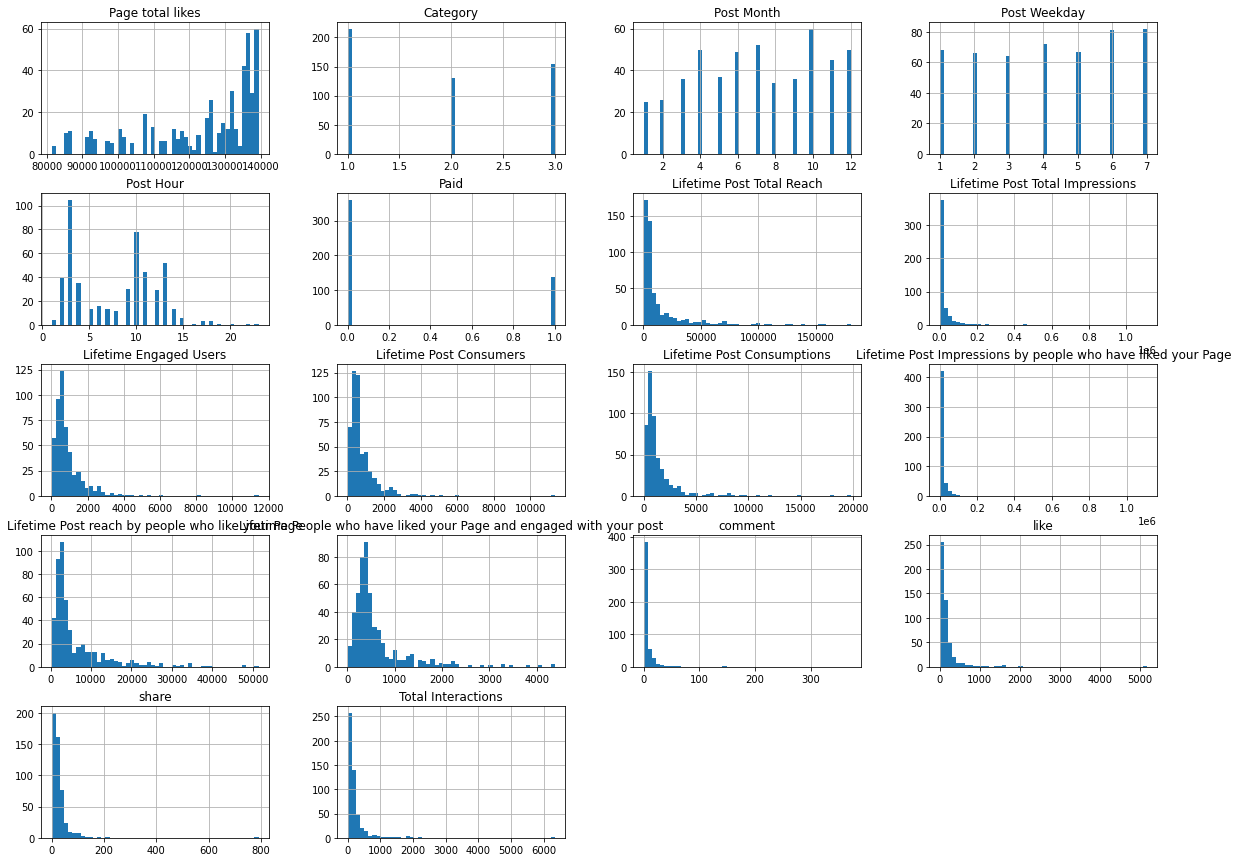

In [ ]:
_ = df.hist(bins=50, figsize=(20,15))

We have some insights from here already which will help us decide how to move forward.

Some ideas:

*   'Category', 'Post Month', 'Post Weekday', 'Post Hour', and 'Paid' appear as numerical features, but they are categorical.</p>
*   Skewed distributions for most of the features -- standardisation or some other way of transforming the features might be needed (or at least attempted in our explorations).

Before we go any further, we should create our separate train and test splits. We will not look at the test set again until the end of the project.

In [ ]:
# Create separate training and test sets. we'll use the training set for steps 3--6
train_set, test_set = train_test_split(df, test_size=0.2, random_state=23)  
# by setting a random_state above, we make sure anytime we run this line we end up with the same train and test sets
print(len(train_set), len(test_set))

400 100


In [ ]:
# Let's make a copy of the training set to ensure we don't mess things up
df = train_set.copy()

What we do from now on depends on the data we're working with. Some examples below.

Let's look only at some potential features

In [ ]:
features = ["Category", "Page total likes", "Type", "Post Month", "Post Hour", "Post Weekday", "Paid"]
df[features].head()

,Category,Page total likes,Type,Post Month,Post Hour,Post Weekday,Paid
61,1,138185,Photo,11,2,3,1.0
13,2,139441,Photo,12,3,5,0.0
183,1,134879,Video,9,10,2,0.0
38,2,138895,Status,12,9,7,0.0
479,3,86909,Photo,1,4,5,0.0


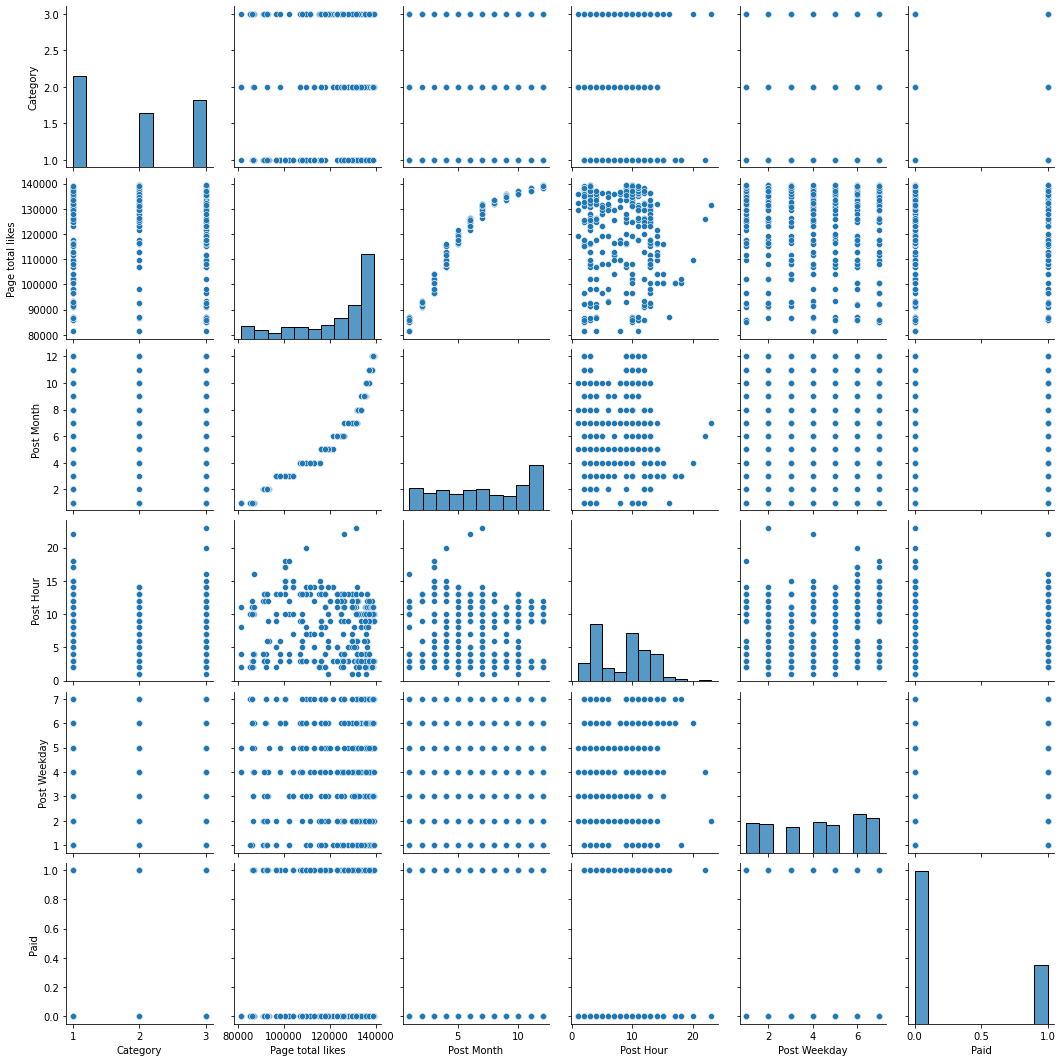

In [ ]:
# Scatterplots
_ = sns.pairplot(df[features])
# An equivalent plot can be done with pandas:
#_ = pd.plotting.scatter_matrix(df[features], figsize=(12, 8))

In [ ]:
# Correlations
correlations = df.corr()  # this is a dataframe
# let's see how much each attribute correlates with the outcome 'like'
correlations['like'].sort_values(ascending=False)

like                                                                   1.000000
Total Interactions                                                     0.997956
share                                                                  0.916424
comment                                                                0.856275
Lifetime Post reach by people who like your Page                       0.634616
Lifetime Engaged Users                                                 0.572801
Lifetime Post Total Reach                                              0.556006
Lifetime People who have liked your Page and engaged with your post    0.501722
Lifetime Post Consumers                                                0.351391
Lifetime Post Total Impressions                                        0.343128
Lifetime Post Impressions by people who have liked your Page           0.247382
Lifetime Post Consumptions                                             0.231878
Paid                                    

Note that correlations only tell us of a LINEAR relationship between two variables. Small correlations do not imply no information at all, only that if there is, it is not linear.

We now have some information about our data that we can use to model. Let's move on to step 4 "Prepare the data for ML", but note that this is an iterative process (insights -> prototype -> analyse -> insights -> ...)

At this stage we can also do feature ingeneering: create more features from the ones you have and check if the correlation with the outcome improves. If we use them in our model, we'll need them later on for our test set as well, but we'll see how to do this below.

# Prepare data for ML algorithms
Use functions were possible:



*   Reproducing on a new dataset is easier
*   Reusable on other projects
*   To transform the data for deployment
*   Can see which transformations work best

First, let's revert to a new clean training set, and separate features from labels (if applicable -- not in unsupervised learning)

In [ ]:
df = train_set.copy()
# Most algorithms cannot work with missing values. Three main ways to deal with them:
# 1. Drop rows
# 2. Drop features with NaNs
# 3. Fill missing values
# As we have very few missing values, let's drop the rows
print("Number of rows before dropping NaNs: %d" % len(df))
df = df.dropna()
print("Number of rows after dropping NaNs: %d" % len(df))
# Separate features from outcomes
y_df = df['like'].copy()
X_df = df[features].copy()

Number of rows before dropping NaNs: 400
Number of rows after dropping NaNs: 396


In [ ]:
# We previously observed that some of the features were categorical. 
# Two main ways to deal with these: OrdinalEncoder() or OneHotEncoding()

# Let's use OneHotEncoding for the categories ('Category', 'Paid', 'Type')
# As we will later want to transform the test set, let's follow good practice and create a custom transformer for a sklearn pipeline

# This is an example of how it would be done. Since this is a very simple transformation, there's a better way of doing it
# using ColumnTransformer. We show it below

class OneHotEncoderCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features):
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cat_features)

In [ ]:
cat_features = ["Category", "Type"]

encoder = OneHotEncoderCategoricalFeatures(cat_features)
X_oho = encoder.transform(X_df)
X_oho

,Page total likes,Post Month,Post Hour,Post Weekday,Paid,Category_1,Category_2,Category_3,Type_Link,Type_Photo,Type_Status,Type_Video
61,138185,11,2,3,1.0,1,0,0,0,1,0,0
13,139441,12,3,5,0.0,0,1,0,0,1,0,0
183,134879,9,10,2,0.0,1,0,0,0,0,0,1
38,138895,12,9,7,0.0,0,1,0,0,0,1,0
479,86909,1,4,5,0.0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
438,98195,3,6,6,0.0,0,1,0,1,0,0,0
457,92828,2,6,3,0.0,1,0,0,0,1,0,0
40,138895,12,11,6,0.0,0,1,0,0,0,1,0
230,131630,7,23,2,0.0,0,0,1,0,1,0,0


In [ ]:
# Let's also look at standardising some of the numerical features
num_features = ['Page total likes']

# Use column transformer: numerical features will be standardised; categorical features will be transformed with OHO

# We can use a ColumnTransformer to transform only some types of columns in different ways
colTransformer = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
    ],
    remainder='passthrough'  # i.e., leave the rest of the columns untouched -- otherwise, they're dropped
    )
print(colTransformer)
X_processed = colTransformer.fit_transform(X_df)
print(X_processed)
print(X_processed[0])
X_processed.shape

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(), ['Page total likes']),
                                ('cat', OneHotEncoder(), ['Category', 'Type'])])
[[ 0.90234462  1.          0.         ...  2.          3.
   1.        ]
 [ 0.97859877  0.          1.         ...  3.          5.
   0.        ]
 [ 0.70163106  1.          0.         ... 10.          2.
   0.        ]
 ...
 [ 0.94545007  0.          1.         ... 11.          6.
   0.        ]
 [ 0.50437809  0.          0.         ... 23.          2.
   0.        ]
 [ 0.84114702  0.          0.         ... 10.          5.
   1.        ]]
[ 0.90234462  1.          0.          0.          0.          1.
  0.          0.         11.          2.          3.          1.        ]


(396, 12)

In [ ]:
X_processed[0,:]

array([ 0.90234462,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        , 11.        ,  2.        ,
        3.        ,  1.        ])

# Regression
We can now train a regressor and then use the bootstrap to find an approximation of the bias and the variance

In [ ]:
y_df

NameError: ignored

In [ ]:
y_df.values

In [ ]:
y = y_df.values
_ = sns.histplot(y, kde=False)
print(y)

In [ ]:
# Since the 'y' is skewed and the range is very large, we can also transform it
y_transformer = StandardScaler()  # we'll need this scaler for the test set later!
y = y_transformer.fit_transform(y.reshape(-1,1))
_ = sns.histplot(y, kde=False)
print(y)

Let's try some models

In [ ]:
clf = DecisionTreeRegressor()  # Decision tree
clf.fit(X_processed, y)
print("MSE of the model = %1.4g" % mse(y, clf.predict(X_processed)))

In [ ]:
n_test = 100
n_repeat = 1000

estimator = RandomForestRegressor()

# Compute predictions
y_predicts = np.ones((n_repeat, len(X_processed))) * np.nan
for i in range(n_repeat):
    sample  = np.random.choice(range(len(X_processed)), replace=True, size=len(X_processed))  # bootstrap!
    train_ids = sample[:-n_test]
    val_ids = sample[-n_test:]
    val_ids = np.setdiff1d(val_ids, train_ids)  # only use those that weren't in the training set for testing
    if len(val_ids) == 0:
        continue
    X_train, y_train = X_processed[train_ids], y[train_ids]
    X_val, y_val = X_processed[val_ids], y[val_ids]
    
    estimator.fit(X_train, y_train.ravel())
    y_predict = estimator.predict(X_val)
    y_predicts[i, val_ids] = y_predict

In [ ]:
y_bias = (y - np.nanmean(y_predicts, axis=0))**2
y_error = np.nanmean((y.T - y_predicts) **2, axis=0)
y_var = np.nanvar(y_predicts, axis=0, ddof = 1)

clf_type = "Random Forest"

print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          "+ {3:.4f} (var)".format(clf_type, np.nanmean(y_error), np.nanmean(y_bias), np.nanmean(y_var)))

print("{0}: {1:.4f} ((bias^2) + (var)) = {2:.4f} (bias^2) "
          "+ {3:.4f} (var)".format(clf_type, np.mean(y_bias) + np.mean(y_var), np.mean(y_bias), np.mean(y_var)))

In [ ]:
#clf = RandomForestRegressor(n_estimators=1000,max_depth=2)
clf = BayesianRidge(normalize=True)
scores = cross_val_score(clf, X_processed, y.ravel(), cv=10, scoring = make_scorer(mse))

dummy_clf = DummyRegressor(strategy='mean')
dummy_scores = cross_val_score(dummy_clf, X_processed, y.ravel(), cv=10, scoring = make_scorer(mse))

print("MSE: %0.8f +/- %0.8f" % (scores.mean(), scores.std()))
print("Dummy MSE: %0.8f +/- %0.8f" % (dummy_scores.mean(), dummy_scores.std()))

# Classification
Let's divide the output of interest into bins, and see if we can do any better

In [ ]:
outcomes_of_interest = ["Lifetime Post Consumers", "like"]
n_bins = 20

# 13	134	137.0
y_df = df[outcomes_of_interest].copy()
# 134	(114.25, 137.0]
y_df["like"], bins = pd.qcut(y_df["like"], n_bins, retbins=True)

outcomesLabelEncoder = LabelEncoder()
# 134	11
y_df['like'] = y_df['like'].apply(outcomesLabelEncoder.fit_transform)

# y_df['id'] = range(1, len(df) + 1)

y_df.head()

,Lifetime Post Consumers,like
61,513,12
13,134,11
183,1956,17
38,5202,16
479,1078,7


In [ ]:
X = X_processed  # Same we used for regression
y = y_df['like'].values.T

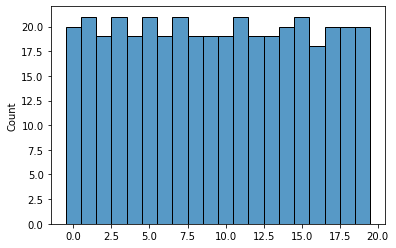

In [ ]:
_ = sns.histplot(y, kde=False)

In [ ]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_processed, y)
print("Dummy ACC: %.2f" % acc(y, dummy_clf.predict(X_processed)))

Dummy ACC: 0.05


In [ ]:
clf = ExtraTreesClassifier(n_estimators=1000, max_depth=4)
scores = cross_val_score(clf, X_processed, y, cv=10, scoring=make_scorer(acc))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.08 +/- 0.03


X_processed [[ 0.90234462  1.          0.         ...  2.          3.
   1.        ]
 [ 0.97859877  0.          1.         ...  3.          5.
   0.        ]
 [ 0.70163106  1.          0.         ... 10.          2.
   0.        ]
 ...
 [ 0.94545007  0.          1.         ... 11.          6.
   0.        ]
 [ 0.50437809  0.          0.         ... 23.          2.
   0.        ]
 [ 0.84114702  0.          0.         ... 10.          5.
   1.        ]]
y [12, 11, 17, 16, 7, ..., 2, 13, 15, 10, 9]
Length: 396
Categories (20, int64): [0 < 1 < 2 < 3 ... 16 < 17 < 18 < 19]
[10  1  8  0  9  4  6  3  5 11  2  7]
Feature ranking:
1. Post Weekday (0.138059)
2. 1 (0.136709)
3. Post Month (0.108756)
4. Page total likes (0.107396)
5. Post Hour (0.099813)
6. Link (0.098992)
7. Status (0.062987)
8. 3 (0.061697)
9. Photo (0.061542)
10. Paid (0.060362)
11. 2 (0.043040)
12. Video (0.020647)


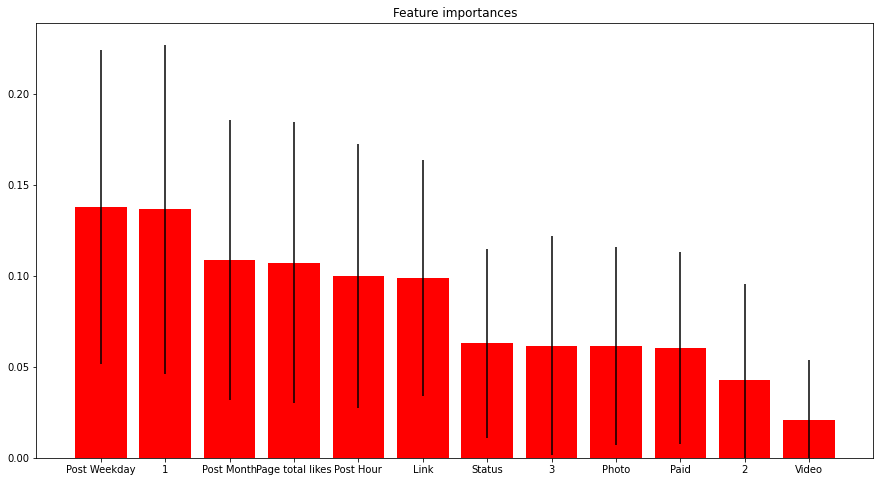

In [ ]:
# Fit the model
clf.fit(X_processed, y)
print("X_processed",X_processed)
print("y",y)
# Let's see the feature importances for our classifier
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(indices)
# Let's get the attibute names:
extra_attribs = ['Post Month', 'Post Hour', 'Post Weekday', 'Paid']  # the ones we didn't modify in the transformer
cat_encoder = colTransformer.named_transformers_['cat']
cat_oho_attributes = oho_categories = [item for sublist in cat_encoder.categories_ for item in sublist]
feat_names = num_features + cat_oho_attributes + extra_attribs

# Print the feature ranking
print("Feature ranking:")
for f in range(X_processed.shape[1]):
    print("%d. %s (%f)" % (f + 1, feat_names[indices[f]],  importances[indices[f]]))

# Plot the feature importances of the forest
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(feat_names)[indices])
plt.xlim([-1, X.shape[1]])
plt.ylim([0, None])

fig.set_size_inches(15, 8)

Now we could try dropping some of the less useful features, or check the errors made by our system. Let's check the confusion matrix.

In [ ]:
# Get prediction on the test set
# Remember we need to do the same operations we did for the training test!
df_test = test_set.copy()
print('Size of test set: %d' % len(df_test))
# Drop rows with nans
df_test = df_test.dropna()
print("Number of rows after dropping NaNs: %d" % len(df_test))

Size of test set: 100
Number of rows after dropping NaNs: 99


In [ ]:
# Separate features from outcomes
print(outcomes_of_interest,features)
y_test_df = df_test[outcomes_of_interest].copy()
X_test_df = df_test[features].copy()
# Transform features
X_test = colTransformer.transform(X_test_df)
assert X_test.shape[1] == X_processed.shape[1]  # same number of features

['Lifetime Post Consumers', 'like'] ['Category', 'Page total likes', 'Type', 'Post Month', 'Post Hour', 'Post Weekday', 'Paid']


In [ ]:
# Make y into categories
# 213	(8.75, 27.0]
y_test_df['like'] = pd.cut(y_test_df['like'], bins=bins, include_lowest=True)  # the bins previously returned by pd.qcut()
y_test_df['like'] = outcomesLabelEncoder.transform(y_test_df['like'])

y_test = y_test_df.values.T[1]  # lifetime post consumers
y_test

array([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1])

In [ ]:
# Predict
test_predictions = clf.predict(X_test)
# What's the accuracy on the test set?
acc(y_test, test_predictions)

0.08080808080808081

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        t = "(%.2f)"%(cm[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


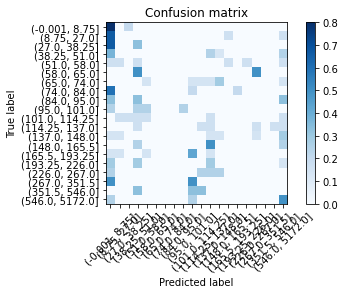

In [ ]:
c = confusion_matrix(y_test, test_predictions)
plot_confusion_matrix(c, outcomesLabelEncoder.classes_)

A good classifier would have high values (i.e., dark blue) on the main diagonal, and low (i.e., light) values elsewhere. In this case, we are not observing that! The accuracy was very low (8%, which is just marginally better than random), so the fact that the results are so bad as seen on the confusion matrix makes sense.

